In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")

import scipy.signal as signal
import scipy.linalg as sclin
import numpy.random as rng
import numpy.linalg as lin
import control as cm
from helperFunctions import *
setPlotStyle()


 ## Textbook input signals

 To generally see how a system output behaves in time, there are two standard signals we like to use:

 1. the Dirac-delta impulse signal

 2. and the (Heaviside) step signal.



 The impulse signal is primarily used to see the transient behaviour of the system and the step functions shows the transient and steady state behaviour. Look at these plots to see! We're even able to seperate the transient from the steady state for the step!

<IPython.core.display.Javascript object>

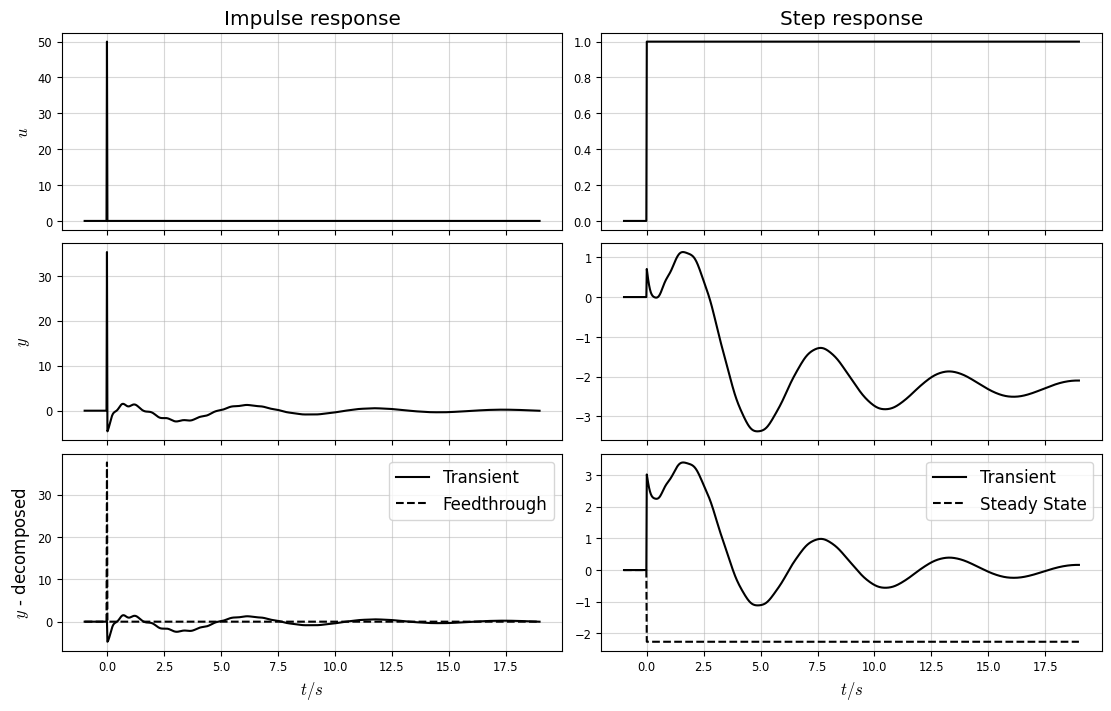

In [19]:
# Create random system
P_res = cm.rss(20)
P_res.D = [rng.rand()]

T_res = np.arange(1000)*0.02 - 1.

## impulse response
impIn = np.zeros_like(T_res)
impIn[int(-T_res[0]/(T_res[1] - T_res[0]))] = 1./(T_res[1] - T_res[0])
impResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = impIn)

impTrans = np.full(len(impResponse.time), np.nan)
impTrans = np.array([(P_res.C@sclin.expm(P_res.A*t)@P_res.B)[0][0] for t in impResponse.time])
impTrans[impResponse.time<0] = 0.0

## step response
stpIn = np.zeros_like(T_res)
stpIn[T_res >= 0] = 1.
stpResponse = cm.forced_response(P_res,
                                 T = T_res,
                                 U = stpIn)

stpTrans = np.zeros_like(T_res)
stpTrans[stpResponse.time >= 0] = np.array([(P_res.C@lin.inv(P_res.A)@sclin.expm(P_res.A*t)@P_res.B)[0][0] 
                        for t in stpResponse.time[stpResponse.time >= 0]])
stpStead = np.zeros_like(T_res)
stpStead[stpResponse.time >= 0] = (P_res.D - P_res.C@lin.inv(P_res.A)@P_res.B)[0][0]

####### Plotting #######
fig, ax = plt.subplots(3,2, sharex='col', figsize=[11, 7])

ax[0,0].set(title="Impulse response", ylabel="$u$")
ax[1,0].set(ylabel="$y$")
ax[2,0].set(xlabel="$t/s$", ylabel="$y$ - decomposed")
ax[0,0].plot(impResponse.time, impResponse.inputs, 'k')
ax[1,0].plot(impResponse.time, impResponse.outputs, 'k')
l1, = ax[2,0].plot(impResponse.time, impTrans, 'k', label="Transient")
l2, = ax[2,0].plot(impResponse.time, np.squeeze(P_res.D*impResponse.inputs), 'k--', label="Feedthrough")
ax[2,0].legend(handles=[l1,l2])

ax[0,1].set(title="Step response")
ax[2,1].set(xlabel="$t / s$")
ax[0,1].plot(stpResponse.time, stpResponse.inputs, 'k')
ax[1,1].plot(stpResponse.time, stpResponse.outputs, 'k')
l1, = ax[2,1].plot(stpResponse.time, stpTrans, 'k', label="Transient")
l2, = ax[2,1].plot(stpResponse.time, stpStead, 'k--', label="Steady State")
ax[2,1].legend(handles=[l1,l2])
display(fig)


 Decomposing a signal into a transient and steady state part? How is that possible? It really comes down to seperating the time dependent and time independent parts. Remember the closed trajectory expression

 $$ x(t) = e^{At}x_0 + \int_0^t e^{A(t-\tau)}Bu(\tau)d\tau$$

 and

 $$ y(t) = Cx(t) + Du(t) = Ce^{At}x_0 + \int_0^t Ce^{A(t-\tau)}Bu(\tau)d\tau + Du(t).$$



 Now assuming $x_0 =0$, and substituting the respective input time-signals yields the solutions

 $$ y_\text{impulse}(t) = \underbrace{Ce^{At}B}_\text{Transient} + \underbrace{D\delta(t)}_\text{Feedthrough}$$

 and

 $$ y_\text{step}(t) = \underbrace{CA^{-1}e^{At}B}_\text{Transient} + \underbrace{D - CA^{-1}B}_\text{Steady State}.$$

 Tada, we've decomposed the signal!



 <div style="text-align:center;background-color:tomato;">End of lecture 5</div>

 ## Feedback control

 WOW ARE WE GOING TO DO CONTROL NOW??? *FINALLY*???? Yes! No... There's one more difference we need to explain. There are two types of feedback control, output and state feedback. The difference is in the name and here you also see the difference in a block diagram for a plant/process/system, $P$, and a controller, $C$.



 ![output vs state feedback](../figures/xyFB.svg)



 Output feedback is stuff like PID, or in other terms: disgusting. We'll look at state feedback now! *The real stuff.*

<IPython.core.display.Javascript object>

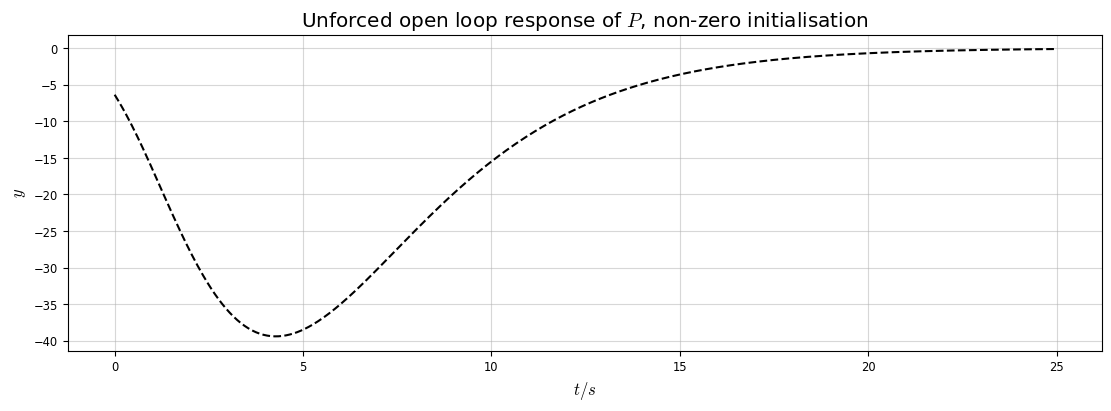

In [20]:
P_reg = cm.ss(cm.zpk(zeros=[-3], 
                     poles=cm.rss(5).poles(), 
                     gain=1, dt=0))
nx_reg = len(P_reg.poles())
x0_reg = rng.randn(nx_reg,1)

T_reg = np.arange(500)*0.05
unforced_reg = cm.forced_response(sysdata=P_reg, 
                              T=T_reg, 
                              X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs, 'k--')
ax.set(title="Unforced open loop response of $P$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")
display(fig)


 We can choose the controller $C: u = -Kx$, and for reachable systems, we can always find a $K$ such that the closed loop system has poles at freely chosen locations. What does that closed loop system look like? Substituting the controller into the state dynamics yields

 $$ \dot x = Ax + Bu = Ax - BKx = (A-BK) x.$$

 So the closed loop system poles are the eigenvalues of $(A-BK)$. If we choose the poles to have a negative real part, the closed loop is stable and the output will go to zero. This type of controller that steers to zero is called a regulator.

<IPython.core.display.Javascript object>

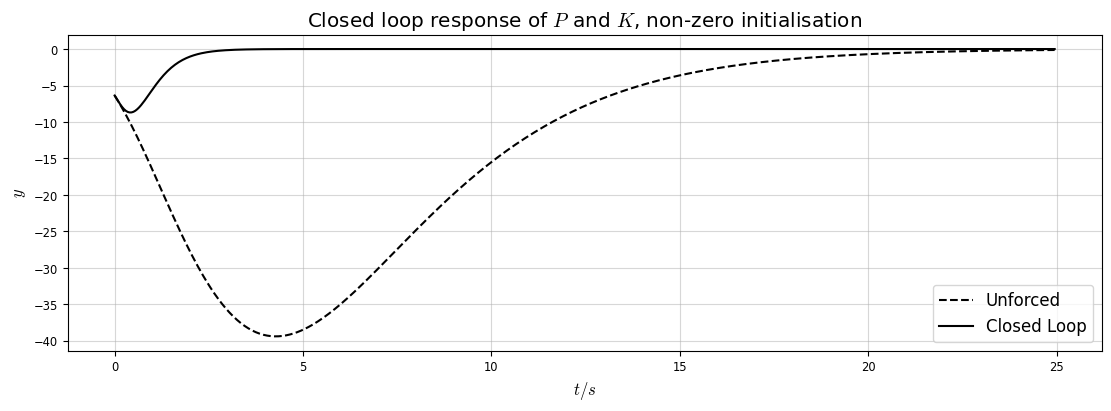

In [21]:
## Check controllability!
def isControlable(A, B):
    Wr = cm.ctrb(A, B)
    return lin.matrix_rank(Wr) == A.shape[0]

assert isControlable(P_reg.A, P_reg.B)==True, "System is uncontrollable D:"

CLpoles_reg = np.linspace(-2, -6, nx_reg)
K_reg = cm.place(P_reg.A, P_reg.B, CLpoles_reg)
CL_reg = cm.ss(P_reg.A-P_reg.B@K_reg, 
                np.zeros([nx_reg,1]), 
                P_reg.C, 
                P_reg.D)

forced_reg = cm.forced_response(sysdata=CL_reg, 
                                T=T_reg, 
                                X0=x0_reg)

####### Plotting #######
fig, ax = plt.subplots()
ax.plot(unforced_reg.time, unforced_reg.outputs, 'k--', label="Unforced")
ax.plot(forced_reg.time, forced_reg.outputs, 'k', label="Closed Loop")
ax.legend()
ax.set(title="Closed loop response of $P$ and $K$, non-zero initialisation", xlabel="$t/s$", ylabel="$y$")
display(fig)


 However, regulating to zero is boring, I want to be able to tell my system to do a backflip! We need to add a reference, and I'll spoil that we also need a reference gain $k_f$:



 ![Reference tracking](../figures/refTrackCL.svg)



 So how does this work then... Same substitution as before!

 $$ \dot x = Ax + Bu = Ax + B(k_f r - Kx) = (A-BK) x + Bk_f r.$$

 Now to determine $k_f$, we want to prevent steady state errors, so $\bar y = r$. Steady state also means

 $$ \dot x = 0 = (A-BK) \bar x + Bk_f r \rightarrow \bar x = -(A-BK)^{-1}Bk_f r.$$

 Now assuming $D=0$ to make things easier, substituting and rewriting gives

 $$\bar y = r \rightarrow C\bar x + \underbrace{D}_{=0}\bar u = C\bar x = r$$

 $$\rightarrow -C(A-BK)^{-1}Bk_f r = r \rightarrow k_f = \frac{-1}{C(A-BK)^{-1}B}.$$



<IPython.core.display.Javascript object>

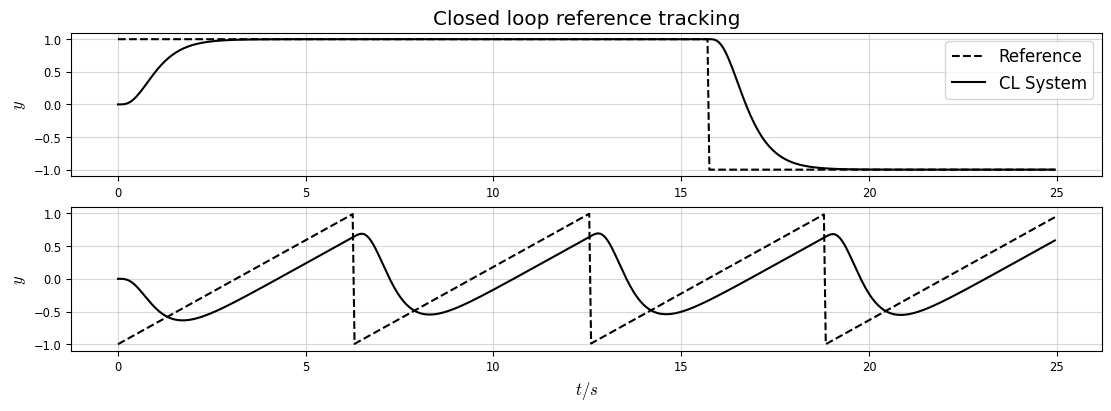

In [22]:
kf_ref = (-1/(P_reg.C@lin.inv(P_reg.A - P_reg.B@K_reg)@P_reg.B))[0,0]

CL_ref = cm.ss(P_reg.A-P_reg.B@K_reg, 
               P_reg.B*kf_ref, 
               P_reg.C, 
               P_reg.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=sqr_ref)
response_saw_ref = cm.forced_response(sysdata=CL_ref, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, 'k', label="CL System")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, 'k', label="CL System")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)




 ## Integral action

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The theory of everything is not found yet, so our model is **always** terrible*



 Most likely the model we have is not a perfect representation of the real world. "Neglect air friction, neglect static/dynamic friction and hysteresis, assume rigid bodies, assume perfect efficiency, ..." All lies we tell ourselves to make our lives easier and to blind ourselves to the harsh reality.



 So if out model is incorrect, what does that mean for our controller? Simply said, it's not exactly what we want, but *it's close*. To get it perfect however, we need to add an output feedback part to our state feedback controller. An integrator of the reference-output-error to be precise. This integrator wil drive the integral of the error, $z$, to zero, meaning that the error will be zero. I'll stop talking now and show the block diagram so you actually understand.



 ![Integral action](../figures/IntActCL.svg)



 Sooooo maths time. Substitute everything into everything, yada yada, this is largely what control engineers do. Also assume D=0. Lets start with plant equations and work our way backwards through the block diagram.

 $$\left\{\begin{aligned}\dot x &= Ax + Bu = Ax + B(k_fr-Kx-k_iz) = (A-BK)x + Bk_fr-Bk_iz \\ y &= Cx\end{aligned}\right.$$

 and

 $$\dot z = y - r = Cx - r.$$

 Augmenting (stacking) the $x$ and $z$ dynamics gives the nice expression

 $$\left\{\begin{aligned}\begin{bmatrix}\dot x\\\dot z\end{bmatrix} &= \begin{bmatrix}(A-BK) & -Bk_i\\ C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix} + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}\begin{bmatrix} x\\ z\end{bmatrix}.\end{aligned}\right.$$

 Saying $q = \begin{bmatrix} x\\ z\end{bmatrix}$ gives the new state space representation

 $$\left\{\begin{aligned}\dot q &= \begin{bmatrix}(A-BK) & -Bk_i\\ C&0\end{bmatrix}q + \begin{bmatrix}Bk_f\\-1\end{bmatrix}r \\ y &= \begin{bmatrix}C&0\end{bmatrix}q.\end{aligned}\right.$$



 Note that the integral error is independent from $A$, so however bad our modeling mistakes are, the integral action will fix it (as long as it's stable). First however, lets look at the nominal behaviour.

<IPython.core.display.Javascript object>

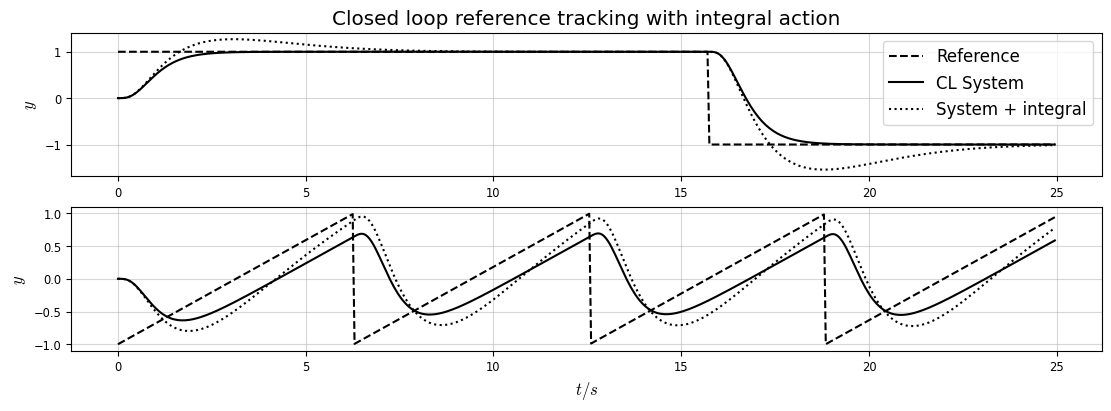

In [23]:
ki = 80. ## CHANGEME

CL_int = cm.ss(np.block([[P_reg.A-P_reg.B@K_reg, -P_reg.B*ki                     ],
                         [P_reg.C,           np.zeros_like(P_reg.C @ P_reg.B)]]), 
               np.vstack((P_reg.B*kf_ref, -1)), 
               np.hstack((P_reg.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=sqr_ref)
response_saw_int = cm.forced_response(sysdata=CL_int, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref.time, response_sqr_ref.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref.time, response_sqr_ref.outputs, 'k', label="CL System")
ax[0].plot(response_sqr_int.time, response_sqr_int.outputs, 'k:', label="System + integral")
ax[1].plot(response_saw_ref.time, response_saw_ref.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref.time, response_saw_ref.outputs, 'k', label="CL System")
ax[1].plot(response_saw_int.time, response_saw_int.outputs, 'k:', label="System + integral")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking with integral action", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)


 And now we face dreadful reality and perturb our plant a little!

<IPython.core.display.Javascript object>

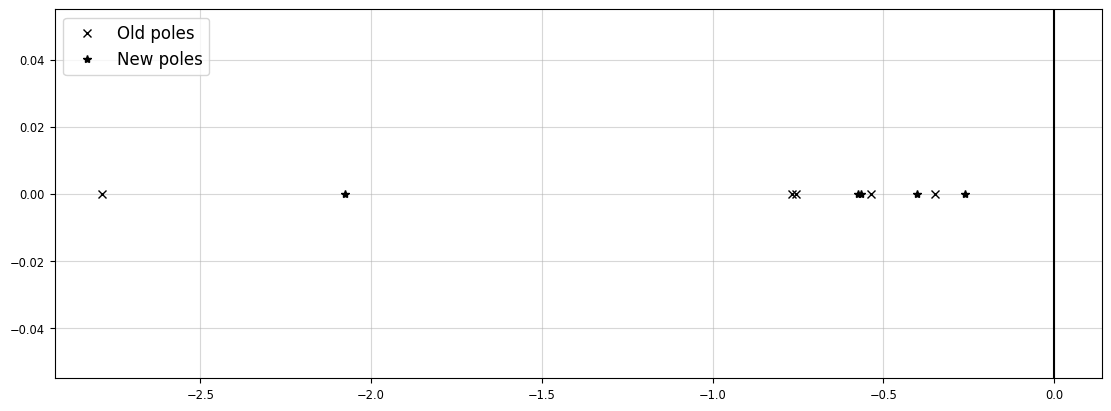

In [26]:
# See https://github.com/python-control/python-control/issues/1188 for the datatype nonsense
ran = np.abs(1. + rng.randn(2) * .3)
poles_pert = [(ran[0] * pole.real + ran[1] * pole.imag*1j).astype(np.complex64) 
                    for pole in P_reg.poles()]

P_pert = cm.ss(cm.zpk(zeros=P_reg.zeros().astype(np.complex64), 
                      poles=poles_pert, 
                      gain=1, dt=0))
P_pert.C *= rng.randn()*.2 + 1.


fig, ax = plt.subplots(1, 1)
ax.axvline(color='k')
s1 = ax.plot(P_reg.poles().real, P_reg.poles().imag, 'kx', label="Old poles")
s2 = ax.plot(P_pert.poles().real, P_pert.poles().imag, 'k*', label="New poles")
ax.legend()
display(fig)


<IPython.core.display.Javascript object>

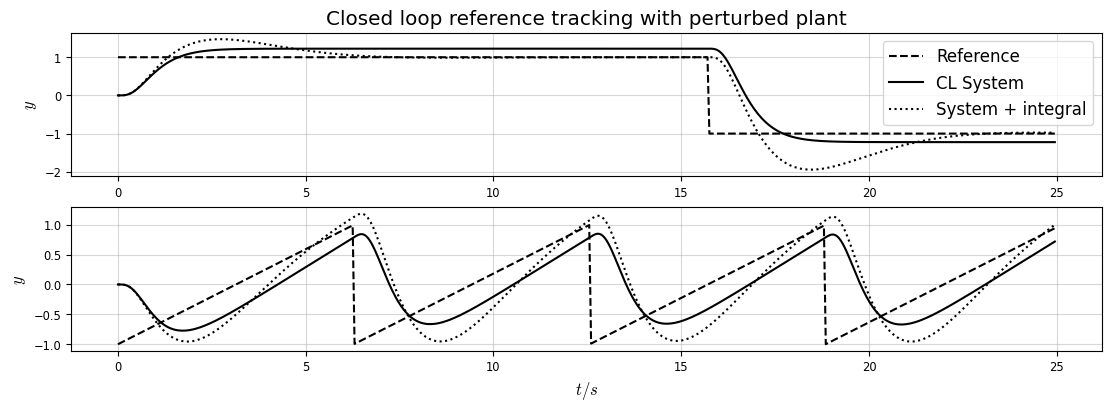

In [27]:
CL_pert = cm.ss(P_pert.A-P_pert.B@K_reg, 
               P_pert.B*kf_ref, 
               P_pert.C, 
               P_pert.D)
sqr_ref = signal.square(t=T_reg*0.2)
saw_ref = signal.sawtooth(t=T_reg)

response_sqr_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=sqr_ref)
response_saw_ref_pert = cm.forced_response(sysdata=CL_pert, T=T_reg, U=saw_ref)

CL_int_pert = cm.ss(np.block([[P_pert.A-P_pert.B@K_reg, -P_pert.B*ki                 ],
                              [P_pert.C,           np.zeros_like(P_pert.C @ P_pert.B)]]), 
               np.vstack((P_pert.B*kf_ref, -1)), 
               np.hstack((P_pert.C, [[0]])), 
               np.zeros([1,1]))

response_sqr_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=sqr_ref)
response_saw_int_pert = cm.forced_response(sysdata=CL_int_pert, T=T_reg, U=saw_ref)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.inputs , 'k--', label="Reference")
ax[0].plot(response_sqr_ref_pert.time, response_sqr_ref_pert.outputs, 'k', label="CL System")
ax[0].plot(response_sqr_int_pert.time, response_sqr_int_pert.outputs, 'k:', label="System + integral")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.inputs , 'k--', label="Reference")
ax[1].plot(response_saw_ref_pert.time, response_saw_ref_pert.outputs, 'k', label="CL System")
ax[1].plot(response_saw_int_pert.time, response_saw_int_pert.outputs, 'k:', label="System + integral")
ax[0].legend()
ax[0].set(title="Closed loop reference tracking with perturbed plant", ylabel="$y$")
ax[1].set(xlabel="$t/s$", ylabel="$y$")
display(fig)


 See how bad the system without the integral action performs? (If not, randomise the plant again...)

 <div style="text-align:center;background-color:tomato;">End of lecture 6</div>

 ## I don't understand art and it should be optimised

 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*If you believe AI artists are artist, you're wrong, but you'll like this part.*



 Linear Quadratic Regulators (LQR) have a special place in my heart. Instead of having a (in some sense) heuristic $K$, smarter people than me came up with the idea of expressing $K$ as the solution to an optimisation problem to obtain *optimal control*. So what optimisation is this? The trick is to balance the control input action and the state deviation, so that calls for the input optimisation

 $$\min_u \int_0^\infty x^\intercal (t) Q_x x(t) + u^\intercal(t) Q_u u(t) dt.$$



 The $Q$ matrices here are semi-positive weighing matrices, the higher the weight, the more penalised the signal.



 The solution to this equation is not easy, but it's found by finding symmetric $S\in\mathbb{R}^{n\times n}, S>0$ such that

 $$A^\intercal S + SA - SBQ^{-1}_uB^\intercal S + Q_x = 0,$$

 which is called the Algebraic Riccati Equation (ARE). Then with this $S$ we can find $K=Q^{-1}_uB^\intercal S$. Also $u=-Kx$, as a reminder. Lets see if you can beat the optimal control!

<IPython.core.display.Javascript object>

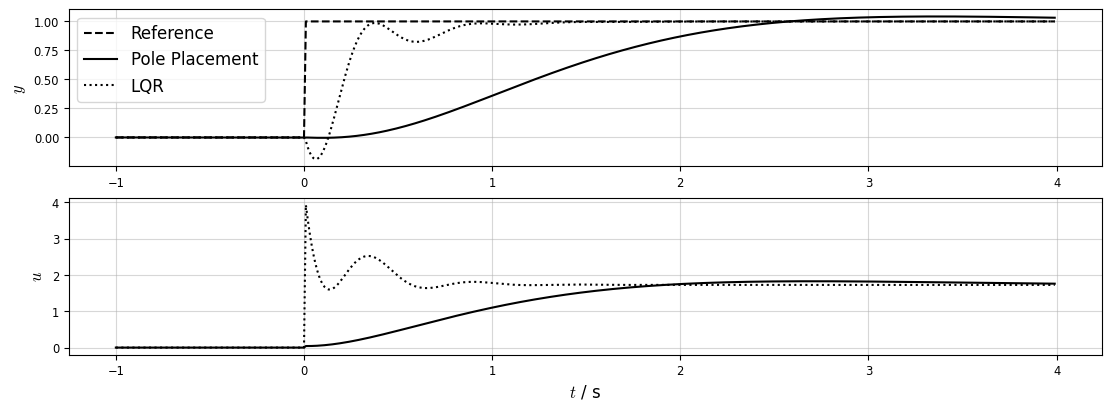

In [9]:
P_lqr = cm.rss(4, strictly_proper=True)
nx_lqr = len(P_lqr.poles())
x0_lqr = rng.randn(nx_lqr,1)

T_lqr = np.arange(500)*0.01 - 1.
step_lqr = np.zeros_like(T_lqr)
step_lqr[T_lqr > 0.] = 1.

assert isControlable(P_lqr.A, P_lqr.B)==True, "System is uncontrollable D:"

## Pole Placement
CLpoles_pp = [-1+1j, -1-1j, -4-2j, -4+2j] ### CHANGEME

K_pp = cm.place(P_lqr.A, P_lqr.B, CLpoles_pp)
kf_pp = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_pp)@P_lqr.B))[0,0]
CL_pp = cm.ss(P_lqr.A-P_lqr.B@K_pp, 
              P_lqr.B*kf_pp, 
              P_lqr.C, 
              P_lqr.D)
response_pp = cm.forced_response(sysdata=CL_pp, 
                                 T=T_lqr, 
                                 U=step_lqr)

## LQR
Qx, Qu = np.eye(nx_lqr)*1e2, np.eye(1)*1 ### CHANGEME

K_lqr, _, _ = cm.lqr(P_lqr.A, P_lqr.B, Qx, Qu) 
kf_lqr = (-1/(P_lqr.C@lin.inv(P_lqr.A - P_lqr.B@K_lqr)@P_lqr.B))[0,0]
CL_lqr = cm.ss(P_lqr.A-P_lqr.B@K_lqr, 
               P_lqr.B*kf_lqr, 
               P_lqr.C, 
               P_lqr.D)
response_lqr = cm.forced_response(sysdata=CL_lqr, 
                                  T=T_lqr, 
                                  U=step_lqr)

fig, ax = plt.subplots(2,1)
ax[0].plot(response_pp.time, response_pp.inputs, 'k--', label="Reference")
ax[0].plot(response_pp.time, response_pp.outputs, 'k', label="Pole Placement")
ax[0].plot(response_lqr.time, response_lqr.outputs, 'k:', label="LQR")
ax[0].legend()
ax[0].set(ylabel="$y$")

ax[1].plot(response_pp.time , (-K_pp  @ response_pp.states)[0,:]  + kf_pp*response_pp.inputs, 'k', label="Pole Placement")
ax[1].plot(response_lqr.time, (-K_lqr @ response_lqr.states)[0,:] + kf_lqr*response_lqr.inputs, 'k:', label="LQR")
ax[1].set(ylabel="$u$", xlabel="$t$ / s")
display(fig)


 <div style="text-align:center;background-color:tomato;">End of lecture 7</div>